In [1]:
import pandas as pd
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from numpy import diag, allclose, corrcoef, array, eye, ones, sqrt, zeros, asarray, cumsum, pi
from numpy.linalg import eig, matrix_rank, inv, cholesky, qr, norm, inv, svd

from scipy import stats

In [2]:
# import data 

## SP futures
es = pd.read_csv('data/es.csv')

## VIX futures
vix1 = pd.read_csv('data/vix1.csv')
vix2 = pd.read_csv('data/vix2.csv')
vix3 = pd.read_csv('data/vix3.csv')

## SP volatility
month1_vol = pd.read_csv('data/1month_vol.csv')
month2_vol = pd.read_csv('data/2month_vol.csv')
month3_vol = pd.read_csv('data/3month_vol.csv')

## SP skew
month1_skew = pd.read_csv('data/1month_skew.csv')
month2_skew = pd.read_csv('data/2month_skew.csv')
month3_skew = pd.read_csv('data/3month_skew.csv')

In [3]:
# clean 

## set date as index
es.set_index('Date', inplace=True)

vix1.set_index('Date', inplace=True)
vix2.set_index('Date', inplace=True)
vix3.set_index('Date', inplace=True)

month1_vol.set_index('Date', inplace=True)
month2_vol.set_index('Date', inplace=True)
month3_vol.set_index('Date', inplace=True)

month1_skew.set_index('Date', inplace=True)
month2_skew.set_index('Date', inplace=True)
month3_skew.set_index('Date', inplace=True)

## drop bad data
vix2 = vix2.drop(['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'], axis=1)
vix3 = vix3.drop(['Unnamed: 6', 'Unnamed: 7'], axis=1)

## reverse time series
es = es.iloc[::-1]

vix1 = vix1.iloc[::-1]
vix2 = vix2.iloc[::-1]
vix3 = vix3.iloc[::-1]

month1_vol = month1_vol.iloc[::-1]
month2_vol = month2_vol.iloc[::-1]
month3_vol = month2_vol.iloc[::-1]

month1_skew = month1_skew.iloc[::-1]
month2_skew = month2_skew.iloc[::-1]
month3_skew = month3_skew.iloc[::-1]

In [4]:
df_futures = es.merge(vix1, left_index=True, right_index=True)
df_futures = df_futures.merge(vix2, left_index=True, right_index=True)
df_multi = df_futures.merge(vix3, left_index=True, right_index=True)
df_multi.head()

,ES_PX_LAST,ES_DAILY_RETURN,ES_PX_VOLUME,1_Future,1_PX_LAST,1_DAILY_RETURN,1_PX_VOLUME,1_DAYS_UNTIL_EXP,2_Future,2_PX_LAST,2_DAILY_RETURN,2_PX_VOLUME,2_DAYS_UNTIL_EXP,3_Future,3_PX_LAST,3_DAILY_RETURN,3_PX_VOLUME,3_DAYS_UNTIL_EXP
Date,,,,,,,,,,,,,,,,,,
1/2/08,1458.50,-0.012693,1623508,F08,23.86,0.032007,1192,13,G08,24.49,0.012402,654,44,H08,24.34,0.006201,128,76
1/3/08,1458.75,0.000171,1266237,F08,23.42,-0.018441,414,12,G08,24.52,0.001225,173,43,H08,24.31,-0.001233,316,75
1/4/08,1423.00,-0.024507,2199479,F08,24.68,0.053800,1146,11,G08,25.30,0.031811,513,42,H08,25.01,0.028795,436,74
1/7/08,1421.50,-0.001054,2436934,F08,24.12,-0.022690,1092,8,G08,24.81,-0.019368,473,39,H08,24.54,-0.018792,267,71
1/8/08,1397.00,-0.017235,2902242,F08,25.54,0.058872,3146,7,G08,25.90,0.043934,938,38,H08,25.52,0.039935,140,70


In [5]:
df_multi_dr = df_multi.drop(['ES_PX_LAST', 
                                'ES_PX_VOLUME', 
                                '1_Future',
                                '1_PX_LAST',
                                '1_PX_VOLUME',
                                '1_DAYS_UNTIL_EXP',
                                '2_Future',
                                '2_PX_LAST',
                                '2_PX_VOLUME',
                                '2_DAYS_UNTIL_EXP',
                                '3_Future',
                                '3_PX_LAST',
                                '3_PX_VOLUME',
                                '3_DAYS_UNTIL_EXP'],
                                axis=1)
df_multi_dr.head()

,ES_DAILY_RETURN,1_DAILY_RETURN,2_DAILY_RETURN,3_DAILY_RETURN
Date,,,,
1/2/08,-0.012693,0.032007,0.012402,0.006201
1/3/08,0.000171,-0.018441,0.001225,-0.001233
1/4/08,-0.024507,0.053800,0.031811,0.028795
1/7/08,-0.001054,-0.022690,-0.019368,-0.018792
1/8/08,-0.017235,0.058872,0.043934,0.039935


In [6]:
df_multi_dr = df_multi_dr[['ES_DAILY_RETURN', '2_DAILY_RETURN', '3_DAILY_RETURN', '1_DAILY_RETURN']]
df_multi_dr.head()

,ES_DAILY_RETURN,2_DAILY_RETURN,3_DAILY_RETURN,1_DAILY_RETURN
Date,,,,
1/2/08,-0.012693,0.012402,0.006201,0.032007
1/3/08,0.000171,0.001225,-0.001233,-0.018441
1/4/08,-0.024507,0.031811,0.028795,0.053800
1/7/08,-0.001054,-0.019368,-0.018792,-0.022690
1/8/08,-0.017235,0.043934,0.039935,0.058872


<IPython.core.display.Javascript object>


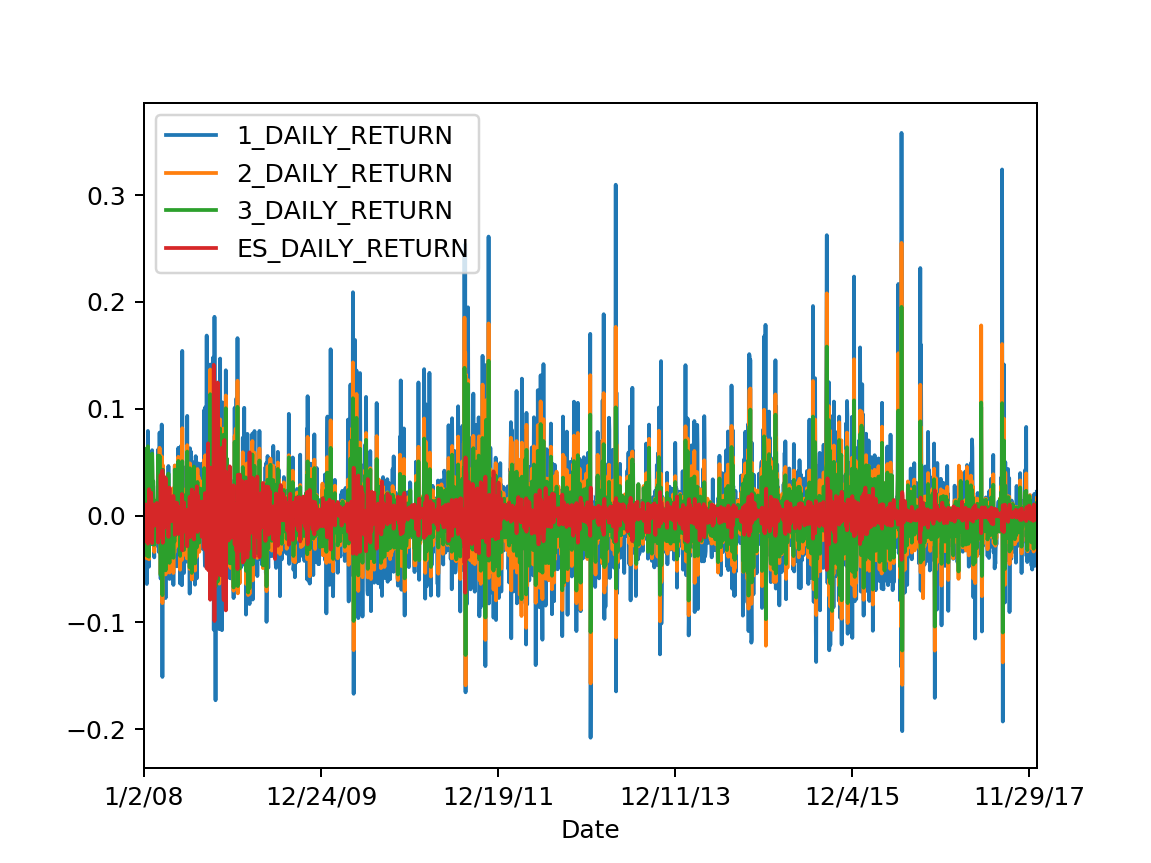

In [7]:
# Daily return comparison 
plot = df_multi_dr[['1_DAILY_RETURN', '2_DAILY_RETURN', '3_DAILY_RETURN', 'ES_DAILY_RETURN']]
plot.plot()

In [8]:
array = df_multi_dr.to_numpy()

In [9]:
A = array[:,0:3].reshape(2522,3)
b = array[:,3].reshape(-1,1)
A

array([[-1.2692503e-02,  1.2401819e-02,  6.2009090e-03],
       [ 1.7140900e-04,  1.2249900e-03, -1.2325390e-03],
       [-2.4507284e-02,  3.1810767e-02,  2.8794735e-02],
       ...,
       [-5.5824300e-04,  0.0000000e+00, -1.9083970e-03],
       [ 9.3100000e-05, -4.0567950e-03,  0.0000000e+00],
       [-3.6302710e-03,  1.6293279e-02,  1.1472275e-02]])

In [ ]:
# Predict 1 Month vix daily return using SP 500 future daily return and 2 and 3 month Vix future daily return

In [10]:
#  Regression using least squares - x_hat = coefficients

x_hat = inv(A.T @ A) @ A.T @ b
p = A @ x_hat
e = b - p
print(x_hat)
print()
print(p)

[[-0.38801957]
 [ 1.37214231]
 [-0.18264366]]

[[ 0.02080944]
 [ 0.00183947]
 [ 0.04789903]
 ...
 [ 0.00056517]
 [-0.00560262]
 [ 0.02166998]]


In [11]:
# attempted R2 score
r2 = 1 - sum((A - A.mean())**2) / sum(e**2)
r2

array([ 0.3131459 , -4.01302048, -2.11659754])

In [12]:
# Regression using svd
U, s, V = svd(A, full_matrices=True)

In [13]:
Ur = U[:,:3]
p2 = Ur @ Ur.T @ b
e2 = b - p2
p2

array([[ 0.02080944],
       [ 0.00183947],
       [ 0.04789903],
       ...,
       [ 0.00056517],
       [-0.00560262],
       [ 0.02166998]])

In [ ]:
# PREDICT

In [14]:
# test using least squares 

x_hat = inv(A[:2000].T @ A[:2000]) @ A[:2000].T @ b[:2000]
p = A[:2000] @ x_hat
e = b[:2000] - p
print(x_hat)
print()
print(p)

[[-0.39680813]
 [ 1.34559096]
 [-0.16988263]]

[[ 0.02067084]
 [ 0.00178971]
 [ 0.04763724]
 ...
 [-0.04755232]
 [ 0.03552791]
 [ 0.07104425]]


In [15]:
# predict using least squares

p = A[-522:] @ x_hat
e = b[-522:] - p
print(p[:5])

[[-0.08544025]
 [ 0.01601601]
 [ 0.0595753 ]
 [ 0.05010473]
 [ 0.00390118]]


In [16]:
# attempt R2 

r2 = 1 - sum((A[-522:] - A[-522].mean())**2) / sum(e**2)
r2

array([-3.30626435, -6.55878634, -4.91899103])

In [ ]:
# sklearn

In [17]:
array = df_multi_dr.to_numpy()

In [18]:
X = array[:,0:3].reshape(2522,3)
y = array[:,3].reshape(-1,1)

In [19]:
# train while holding out a portion of the data, then use the model train and test over holdout data

from sklearn.model_selection import train_test_split

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state=42)
X_test, X_manual, y_test, y_manual = train_test_split(X_holdout, y_holdout, random_state=42)

In [20]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X_train, y_train)
score = model.score(X_test, y_test)

print(f"R2 Score: {score}")

R2 Score: 0.9027306012389575


In [ ]:
# note - sklearn coeffiecents are close to least square method used above

In [21]:
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)
print(type(X))
print(type(y))

Weight coefficients:  [[-0.35484498  1.33267484 -0.12595473]]
y-axis intercept:  [5.22394551e-05]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# graph predicted data against actual 

In [22]:
y_prediction_list = []
y_actual_list = []

for i, X_example in enumerate(X_manual):
    y_prediction = model.predict([X_example])
    y_actual = y_manual[i]
    y_prediction_list.append(y_prediction[0][0])
    y_actual_list.append(y_actual[0])    

<IPython.core.display.Javascript object>


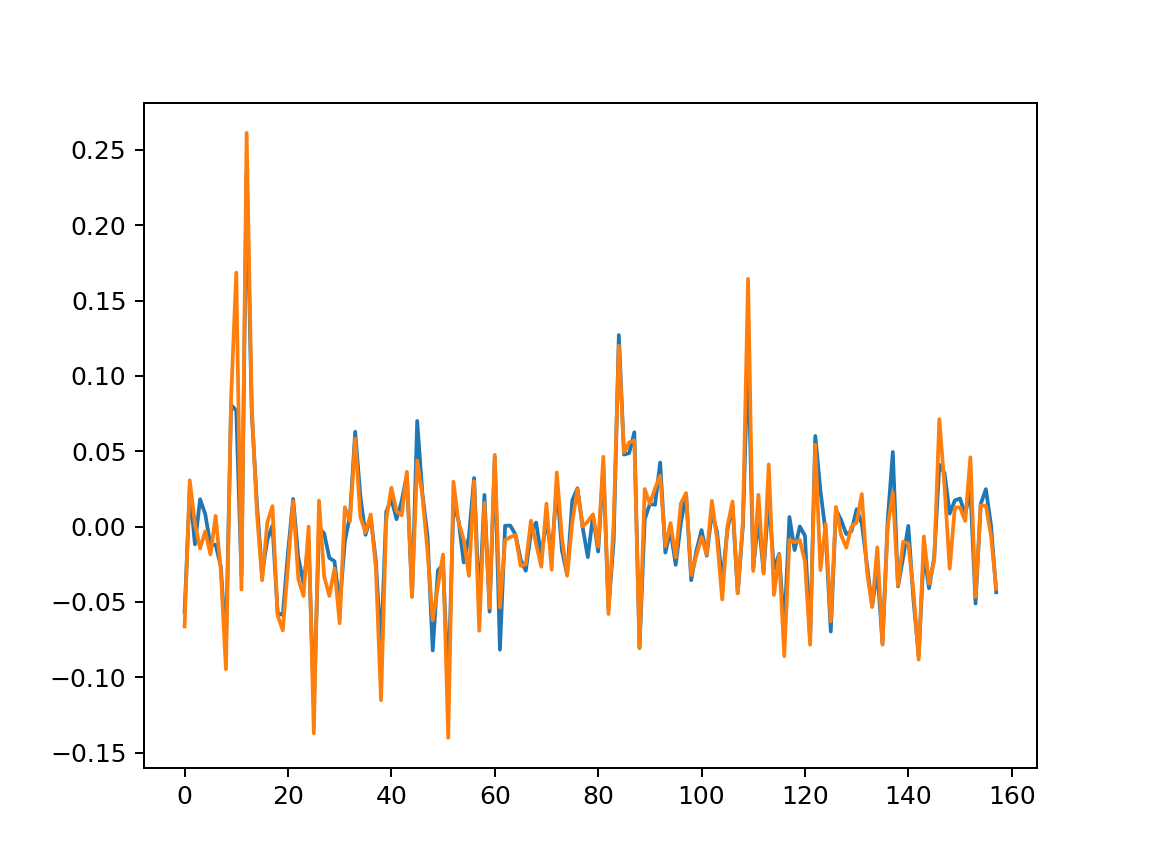

In [25]:
plt.plot(y_prediction_list)
plt.plot(y_actual_list)

<IPython.core.display.Javascript object>


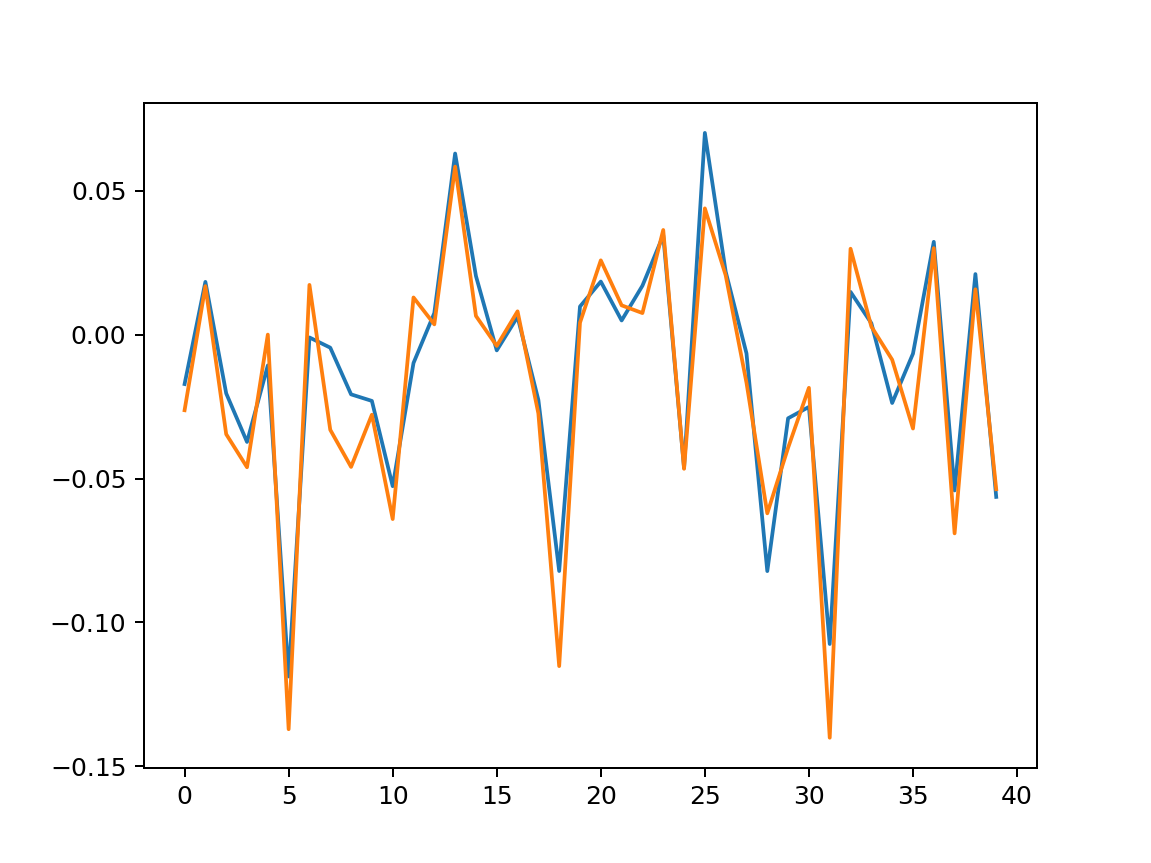

In [34]:
# 'zoomed' graph
plt.plot(y_prediction_list[20:60])
plt.plot(y_actual_list[20:60])

In [43]:
prediction = asarray(y_prediction_list).reshape(-1,1)
actual = asarray(y_actual_list).reshape(-1,1)
error = prediction - actual

In [44]:
error.shape

(158, 1)

In [45]:
# calculate mean error, variance, and standard error 
# calculate mean error in dollar terms against average 1 month vix future
# calculate max and minimimum error in dollar terms - note the dollar errors are significantly large versus the 
    # average error --- while the model can usually predict closely the errors are large enough even though infrequent
    # to make the entire model questionable for practical use

m = np.mean(error)
v = np.var(np.array(error))
s = np.sqrt(v / 158)

print(m, v, s)
print()
print(m*20.67)
print()
print(max(error))
print(max(error*20.67))
print()
print(min(error))
print(min(error*20.67))

0.0006220123531233801 0.0002315619985257141 0.0012106123529644366

0.012856995339060267

[0.05270394]
[1.08939053]

[-0.09167969]
[-1.89501911]


<IPython.core.display.Javascript object>


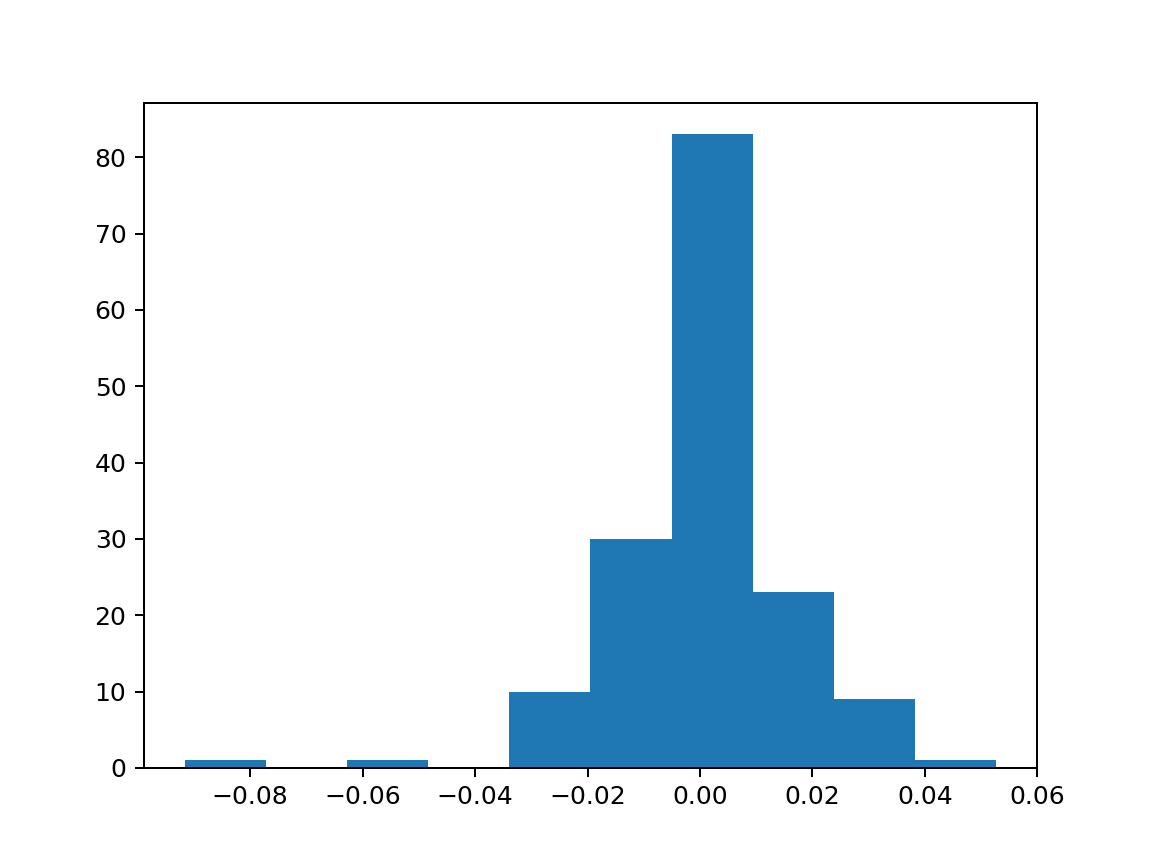

(array([ 1.,  0.,  1.,  0., 10., 30., 83., 23.,  9.,  1.]),
 array([-0.09167969, -0.07724132, -0.06280296, -0.0483646 , -0.03392623,
        -0.01948787, -0.00504951,  0.00938886,  0.02382722,  0.03826558,
         0.05270394]),
 <a list of 10 Patch objects>)

In [39]:
# histogram of error in model, significant outliers
plt.hist(error)

691.1503837897544

7.978845608028654

0.98304
3.0
7.46496
